# Optimization test

In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
import os
import json
from copy import deepcopy
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import lib.galaxy_utilities as gu
import gzbuilder_analysis.parsing as parsing
import gzbuilder_analysis.aggregation as aggregation
import gzbuilder_analysis.rendering as rendering
from sklearn.metrics import mean_squared_error
import gzbuilder_analysis.fitting as fitting
from tqdm import tqdm
from gzbuilder_analysis.fitting._model import Model
from scipy.optimize import minimize
from gzbuilder_analysis.config import PARAM_BOUNDS

In [3]:
subject_id = 20902041

Make a model which is just a disk:

In [110]:
m_to_fit = deepcopy(models.iloc[0])
# m_to_fit['bulge'] = None
m_to_fit['bar'] = None
m_to_fit['spiral'] = np.array([])

m = Model(m_to_fit, galaxy_data, psf=psf, pixel_mask=pixel_mask)

Define our handy loss function

In [111]:
def loss(rendered_model, galaxy_data, pixel_mask=None):
    if pixel_mask is None:
        pixel_mask = np.ones_like(rendered_model)
    Y = rendered_model * pixel_mask
    return mean_squared_error(
        (rendered_model * pixel_mask).flatten(),
        0.8 * (galaxy_data * pixel_mask).flatten()
    )

Run the optimization

In [112]:
t_bounds = [PARAM_BOUNDS[k] for _, k in m._template]
p0 = m.to_p()
def f(p):
    model = m.from_p(p)
    r = rendering.calculate_model(
        model,
        image_size=diff_data['imageData'].shape[0],
        psf=psf,
    )
    l = loss(r, galaxy_data, pixel_mask=pixel_mask)
    return l

with tqdm(desc='Fitting model') as pbar:
    def update_bar(p):
        pbar.update(1)
    res = minimize(f, p0, bounds=t_bounds, callback=update_bar)

new_model = m.from_p(res['x'])
res

Fitting model: 12it [00:54,  4.00s/it]


      fun: 0.00072114728901658
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.67296861e-06, -1.43484400e-06,  6.33900484e-07,  2.39722521e-06,
       -3.46597751e-06,  3.34726821e-06,  1.77777714e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 112
      nit: 12
   status: 0
  success: True
        x: array([ 0.11011509, 89.87265587,  0.6534187 ,  0.73328451,  7.20592169,
        0.80853461,  1.04220664])

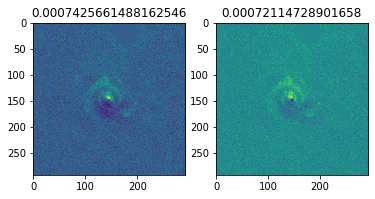

In [113]:
__render_model = lambda m: rendering.calculate_model(
    m,
    image_size=diff_data['imageData'].shape[0],
    psf=psf
)
def render(m):
    return rendering.calculate_model(
        m, psf=psf,
        image_size=diff_data['imageData'].shape[0],
    )
def get_diff(m):
    return rendering.compare_to_galaxy(
        render(m), galaxy_data,
        pixel_mask=pixel_mask, stretch=False
    )

plt.subplot(121)
plt.title(loss(render(m_to_fit), galaxy_data, pixel_mask))
plt.imshow(get_diff(m_to_fit))
plt.subplot(122)
plt.title(loss(render(new_model), galaxy_data, pixel_mask))
plt.imshow(get_diff(new_model))

In [118]:
from gzbuilder_analysis.fitting._cache import CachedModel

In [172]:
m_ = Model(m_to_fit, galaxy_data, psf=psf, pixel_mask=pixel_mask)
c = CachedModel(m_to_fit, galaxy_data, psf=psf, pixel_mask=pixel_mask)
c

In [176]:
t_bounds = [PARAM_BOUNDS[k] for _, k in c._template]
p0 = c.to_p()
def f(p):
    model = c.from_p(p)
    r = c.cached_render(model)
    l = loss(r, galaxy_data, pixel_mask=pixel_mask)
    return l
  
def f2(p):
    model = c.from_p(p)
    r = c.render(model)
    l = loss(r, galaxy_data, pixel_mask=pixel_mask)
    return l

def f3(p):
    model = c.from_p(p)
    r = rendering.calculate_model(
        model, psf=psf,
        image_size=diff_data['imageData'].shape[0],
    )
    l = loss(r, galaxy_data, pixel_mask=pixel_mask)
    return l

with tqdm(desc='Fitting model using cache') as pbar:
    def update_bar(p):
        pbar.update(1)
    res = minimize(f, p0, bounds=t_bounds, callback=update_bar)

with tqdm(desc='Fitting model without cache') as pbar:
    def update_bar(p):
        pbar.update(1)
    res2 = minimize(f2, p0, bounds=t_bounds, callback=update_bar)

with tqdm(desc='Fitting model from original code') as pbar:
    def update_bar(p):
        pbar.update(1)
    res3 = minimize(f3, p0, bounds=t_bounds, callback=update_bar)

Fitting model using cache: 12it [00:37,  2.79s/it]
Fitting model without cache: 12it [00:58,  4.36s/it]
Fitting model from original code: 12it [01:00,  4.26s/it]


In [178]:
display(res['x'])
display(res2['x'])
display(res3['x'])

array([ 0.11011509, 89.87265587,  0.6534187 ,  0.73328451,  7.20592169,
        0.80853461,  1.04220664])

array([ 0.11011509, 89.87265587,  0.6534187 ,  0.73328451,  7.20592169,
        0.80853461,  1.04220664])

array([ 0.11011509, 89.87265587,  0.6534187 ,  0.73328451,  7.20592169,
        0.80853461,  1.04220664])